### DL Assignment 2 
Implement a cnn model having 2 convolusion block, each convolusion block consists of convolusion layer which is followed by a relu function and then downsampled using max pooling. The 2nd conv block is then followed by 2 fully connected layers. We need to draw a scatter plot of gradient norm vs epoch.

Import the required libraries

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms

In [4]:
print(torch.__version__)

1.7.0+cu101


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Download the data and then normalize it so that we get a distribution with a mean of 0.1307 and a standard deviation of 0.3081.

In [6]:
train_set = dataset.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

test_set = dataset.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081))                                 
    ])
)

In [7]:
# initialising batch size for training and testing
bs = 100

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = bs, shuffle=True)

To calculate the output dimension, we will use formula : `W_out = ((W_in - F + 2P)/S) + 1`

where 
W : width,
S : number of stride,
F = filter size (or kernel size)

`1st Layer = Conv1 (using 5 * 5 kernel) + Relu + MaxPooling (using 2 * 2 kernel)`
>The output of 1st layer is 14 * 14 * 32 i.e., there are 32 channels and each image is having 14 * 14 dimension.

`2nd Layer = Conv2 (using 5 * 5 kernel) + Relu + MaxPooling (using 2 * 2 kernel)`
>The output of 2nd layer is 7 * 7 * 64 i.e., there are 64 channels and each image is having 7 * 7 dimension.
 
We have used maxpooling to down-sample the data by reducing the effective image size by a factor of 2. 

#### Define the neural network structure

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride = 1, padding=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 1000)
        self.fc2 = nn.Linear(1000,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # flatten the data dimension from 7*7*64 into 3136*1 (i.e., reshaping the tensor)
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = self.fc2(x)
# No need to use softmax function as it is already included in CrossEntropyLoss()
        return x

In [14]:
num_epochs = 500
log_interval = 10
learning_rate = 0.001
train_counter = []
train_losses = []

#### Define the loss function and optimisation algorithm

In [11]:
model = ConvNet()
model.to(device) # transfer to GPU if available
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

#### Training the model

In [15]:
gradient_norm = []
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 55)
# Train the model
    model.train() 
    for batch_idx, data_set in enumerate(train_loader):
        
        data , target = data_set
        data = data.to(device)
        target = target.to(device)
        # Forward propagation
        optimizer.zero_grad()  # set gradients to zero
        output = model(data)   
        output.to(device)
        loss = loss_func(output,target) # compute loss

        # Back propagation and perform adam optimization
        loss.backward() # calculate gradients
        optimizer.step()  # update weights

        if batch_idx % log_interval == 0:
         print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
           epoch, batch_idx * len(data), len(train_loader.dataset),
           100. * batch_idx / len(train_loader), loss.item()))
         
        train_losses.append(loss.item())
        train_counter.append((batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))
    
    total_tr_loss = sum(train_losses)/(batch_idx + 1)
    print(f"Total train loss : {total_tr_loss}")
    # Calculating gradient norm
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad and "bias" not in name:
            # Uncomment any of the below line if you want to see the gradient values
            #print (name, param.grad.data)
            #print(f'{name}.grad', param.grad, epoch)
            gradients.append(torch.flatten(param.grad.data))
    print(f'Grad_norm : {torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0))}')
    gradient_norm.append(torch.norm(torch.cat([gradients[0],gradients[1],gradients[2],gradients[3]],dim=0)).item())

Streaming output truncated to the last 5000 lines.
Train Epoch: 421 [19000/60000 (32%)]	 Loss: 0.000000
Train Epoch: 421 [20000/60000 (33%)]	 Loss: 0.000000
Train Epoch: 421 [21000/60000 (35%)]	 Loss: 0.000000
Train Epoch: 421 [22000/60000 (37%)]	 Loss: 0.000000
Train Epoch: 421 [23000/60000 (38%)]	 Loss: 0.000000
Train Epoch: 421 [24000/60000 (40%)]	 Loss: 0.000000
Train Epoch: 421 [25000/60000 (42%)]	 Loss: 0.000000
Train Epoch: 421 [26000/60000 (43%)]	 Loss: 0.000000
Train Epoch: 421 [27000/60000 (45%)]	 Loss: 0.000000
Train Epoch: 421 [28000/60000 (47%)]	 Loss: 0.000000
Train Epoch: 421 [29000/60000 (48%)]	 Loss: 0.000000
Train Epoch: 421 [30000/60000 (50%)]	 Loss: 0.000000
Train Epoch: 421 [31000/60000 (52%)]	 Loss: 0.000000
Train Epoch: 421 [32000/60000 (53%)]	 Loss: 0.000000
Train Epoch: 421 [33000/60000 (55%)]	 Loss: 0.000000
Train Epoch: 421 [34000/60000 (57%)]	 Loss: 0.000000
Train Epoch: 421 [35000/60000 (58%)]	 Loss: 0.000000
Train Epoch: 421 [36000/60000 (60%)]	 Loss: 0.00

In [16]:
# Gradient norm for each epoch
#print(gradient_norm)
print(len(gradient_norm))

500


In [17]:
ep = [e for e in range(num_epochs)]
#ep

#### Evaluating and testing the model

In [18]:
correct = 0
total = 0
pred = []
# Test the model
model.eval()
test_loss = 0
for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  test_loss += loss_func(output,target)
  _, predicted = torch.max(output.data,1)
  pred.append(output)
  total += target.size(0)
  correct += (predicted == target).sum().item()

test_loss = test_loss/len(test_loader.dataset)
print('Average loss for the test set is {} \nThe test accuracy of the 2-layered cnn model on the {} test images: {} %'.format(test_loss, len(test_set),(correct / (total)) * 100))

Average loss for the test set is 0.037344757467508316 
 The test accuracy of the 2-layered cnn model on the 10000 test images: 99.19 %


#### Plot of gradient norm vs epoch

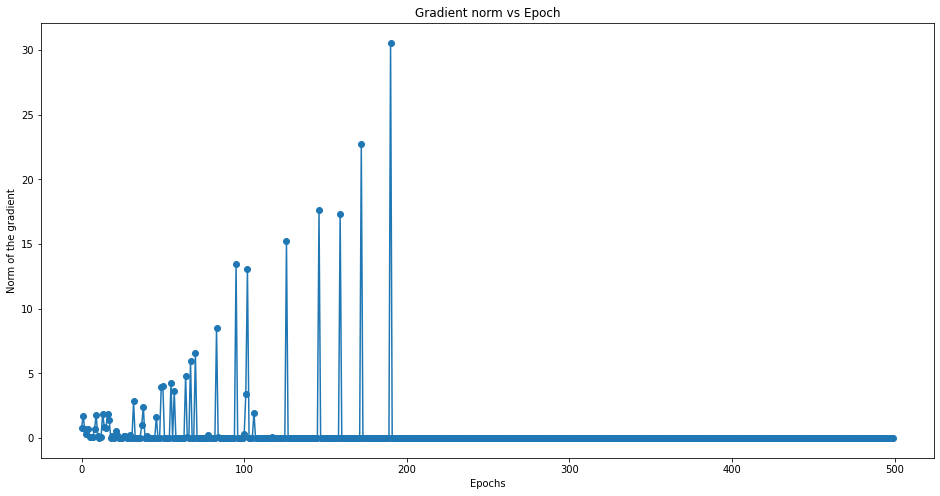

In [19]:
fig = plt.figure()
fig.set_size_inches(16, 8)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
plt.scatter(ep,gradient_norm)
plt.plot(ep,gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 500 epoch).pdf',dpi = 300)

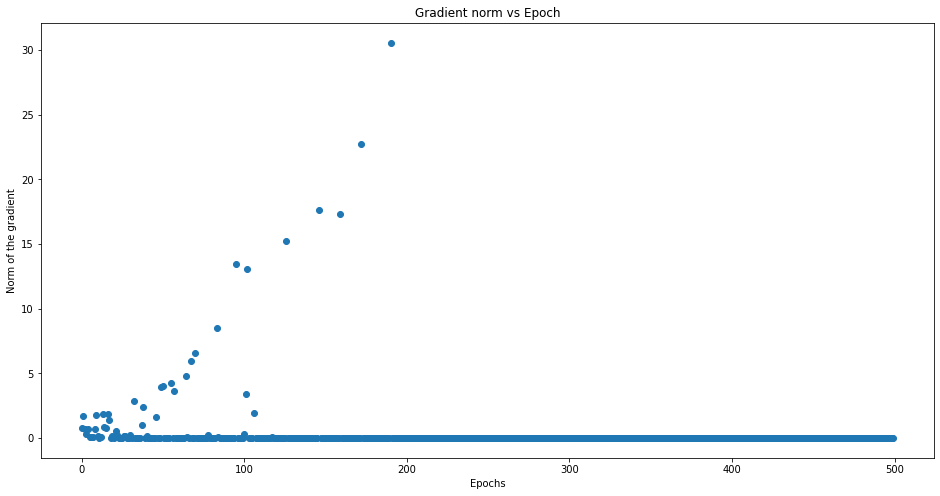

In [23]:
fig = plt.figure()
fig.set_size_inches(16, 8)
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
plt.scatter(ep,gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 500 epochs).pdf',dpi = 300)

Below is the plot of gradient norm vs epoch (considering total number of epoch = 100).
In that case, the test accuracy of the model on the 10000 test images was 95.22 %.

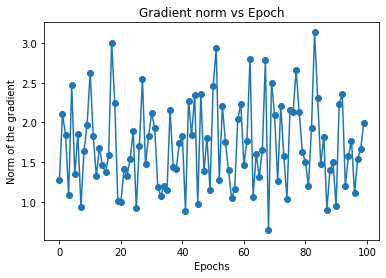

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Norm of the gradient")
plt.scatter(ep,gradient_norm)
plt.plot(ep,gradient_norm)
plt.title("Gradient norm vs Epoch")
plt.savefig('scatter plot of gradient norm vs epoch (with 100 epoch).pdf', dpi = 300)
plt.show();

In [21]:
from google.colab import files
#files.download('scatter plot of gradient norm vs epoch (with 100 epoch).pdf')

In [22]:
files.download('scatter plot of gradient norm vs epoch (with 500 epoch).pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>